In [15]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
import geopandas as gpd

In [2]:
data = pd.read_csv('../01_data/04_output/data.csv')

In [3]:
data['DATETIME'] = pd.to_datetime(data['CRASH DATE'] + ' ' + data['CRASH TIME'])

In [4]:
# Define the logit function
def logit(p):
    return np.log(p / (1 - p))

In [5]:
epsilon = 1e-5 
data['logit_severity'] = data['severity'].apply(lambda x: logit(x + epsilon))
data['population'] = data['population'].str.replace(',', '').astype(int)

In [6]:
train_data = data.loc[data['DATETIME'] < pd.Timestamp('2024-1-1 00:00')]
test_data = data.loc[data['DATETIME'] > pd.Timestamp('2024-1-1 00:00')]

In [7]:
lm = smf.ols(formula='severity~gravity_to+median_income+population+degree-1', data = train_data).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:               severity   R-squared (uncentered):                   0.774
Model:                            OLS   Adj. R-squared (uncentered):              0.774
Method:                 Least Squares   F-statistic:                          9.538e+04
Date:                Sat, 04 May 2024   Prob (F-statistic):                        0.00
Time:                        14:49:40   Log-Likelihood:                     -1.5700e+05
No. Observations:              111545   AIC:                                  3.140e+05
Df Residuals:                  111541   BIC:                                  3.140e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [8]:
import matplotlib.pyplot as plt
# Predict in-sample (training data)
in_sample_preds = lm.predict(train_data)

# Calculate in-sample MSE
in_sample_mse = np.mean((train_data['severity'] - in_sample_preds) ** 2)

# Predict out-of-sample (testing data)
out_sample_preds = lm.predict(test_data)

# Calculate out-of-sample MSE
out_sample_mse = np.mean((test_data['severity'] - out_sample_preds) ** 2)

# Print MSEs
print("In-sample MSE:", in_sample_mse)
print("Out-of-sample MSE:", out_sample_mse)


In-sample MSE: 0.9774182044448056
Out-of-sample MSE: 1.0076818378723615


In [9]:
data['predict'] = lm.predict(data)

In [12]:
df = data.groupby(by=['LONGITUDE','LATITUDE'])[['severity','CRASH TIME','predict']].agg({'severity':'sum','CRASH TIME':'count','predict':sum}).reset_index()

In [25]:
df.dtypes

LONGITUDE     float64
LATITUDE      float64
severity      float64
CRASH TIME      int64
predict       float64
dtype: object

In [32]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']), crs='EPSG:4326')

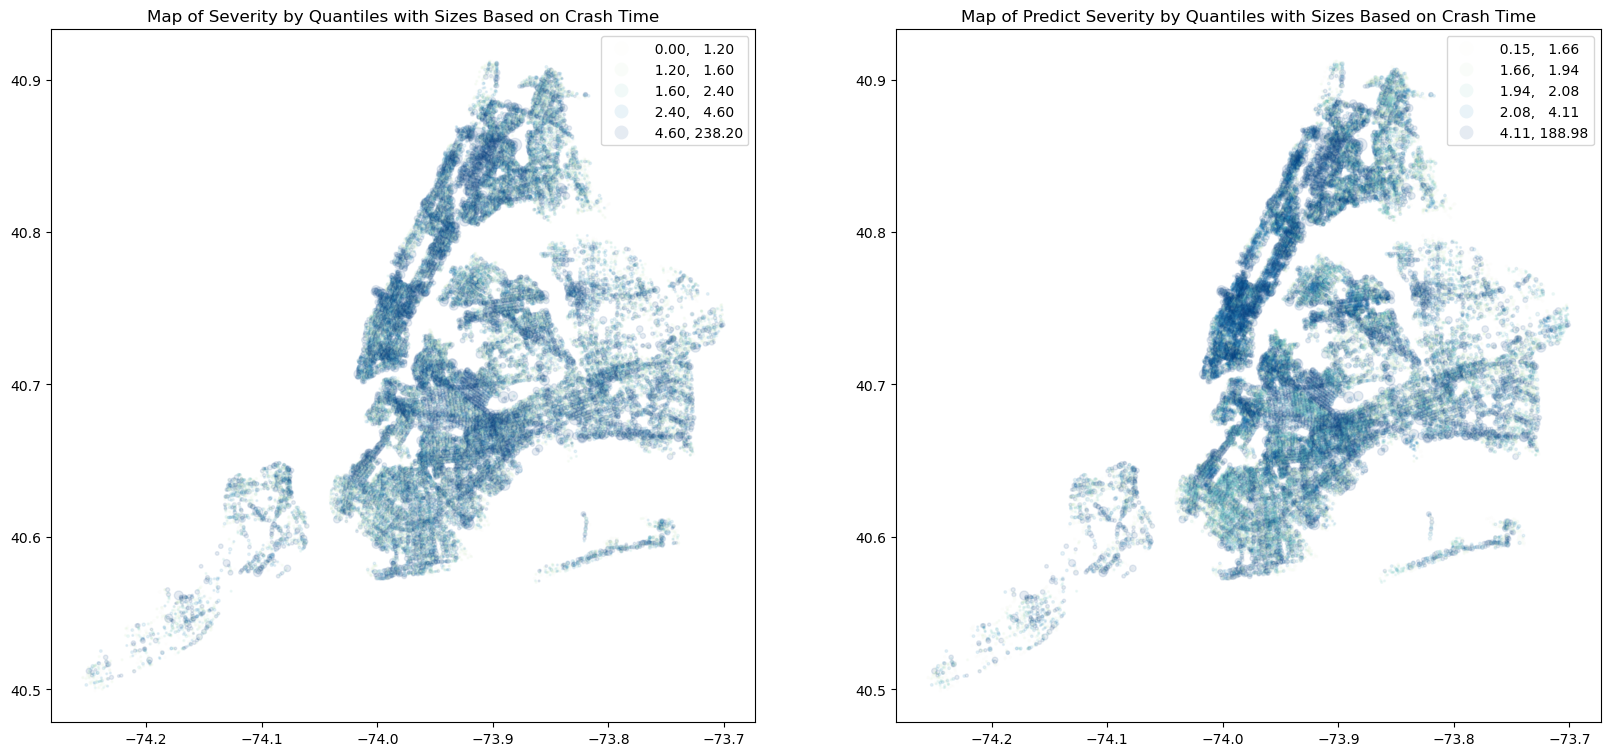

In [42]:
# Normalize 'CRASH TIME' for the size of the points. Adjust the scale as needed.
size = gdf['CRASH TIME'] / gdf['CRASH TIME'].max() * 200  # Scale factor for visibility

# Plot
fig, ax = plt.subplots(1, 2, figsize=(20, 12))  # Adjust the size as necessary

gdf.plot(ax=ax[0], column='severity', legend=True, scheme='quantiles', cmap='GnBu',
         markersize=size, alpha=0.1)  # Use a colormap that fits your data's story
ax[0].set_title('Map of Severity by Quantiles with Sizes Based on Crash Time')


gdf.plot(ax=ax[1], column='predict', legend=True, scheme='quantiles', cmap='GnBu',
         markersize=size, alpha=0.1)  # Use a colormap that fits your data's story

ax[1].set_title('Map of Predict Severity by Quantiles with Sizes Based on Crash Time')

# Show the plot
plt.show()

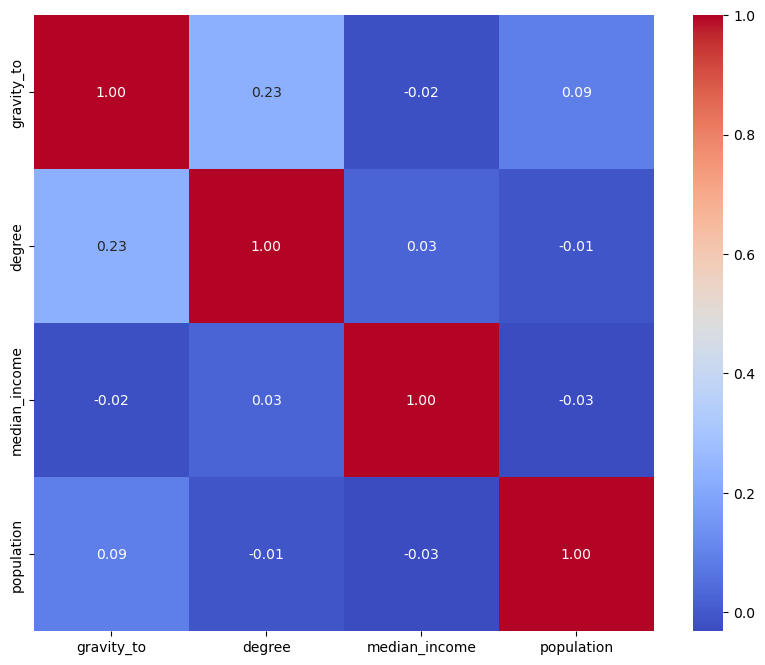

In [59]:
corr_matrix = data[['gravity_to', 'degree', 'median_income', 'population']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'data' contains all your predictors
vif_data = pd.DataFrame()
vif_data["feature"] = ['gravity_to', 'degree', 'median_income', 'population']
datax = data[['gravity_to', 'degree', 'median_income', 'population']]
vif_data["VIF"] = [variance_inflation_factor(datax.values, i) for i in range(data.shape[1])]

print(vif_data)

         feature        VIF
0     gravity_to   4.968909
1         degree  10.182904
2  median_income   3.965423
3     population   4.942782
